# HW5 - Binary Classification using Swin Transformer
Intelligent Analysis of Biomedical Images

Fall 2023

- Name: Amir Mohammad Ezzati
- Student id: 402212269

**Introduction**:

In this educational notebook, we will explore binary classification on the BreastMNIST dataset, consisting of 780 breast ultrasound images. This task involves using the Swin Transformer, a cutting-edge neural network model, to distinguish between benign (including normal) and malignant cases.

We'll tackle the common challenge of class imbalance in medical datasets and learn to improve model performance using class weights. Additionally, we'll delve into evaluating our model with ROC curves and AUC, essential tools for assessing performance in medical image classification.


## Packages & Modules

In [ ]:
!pip install torchmetrics
!pip install timm
!pip install medmnist

In [2]:
from IPython.display import clear_output

import torch
from tqdm import tqdm
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from collections import Counter

from torchmetrics import Accuracy, F1Score, ConfusionMatrix

from torchmetrics import Accuracy
from timm import create_model
import medmnist
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
clear_output()

## Data

The BreastMNIST dataset is simplified into a binary classification problem, merging normal and benign images into a single class, contrasting against malignant images. The dataset, originally 1×500×500 in size, is resized to 1×28×28 and split into training, validation, and test sets. We address the class imbalance by applying class weights in our loss function, enhancing the focus on underrepresented classes.

In [ ]:
info = medmnist.INFO['breastmnist']
n_channels = info['n_channels']

DataClass = getattr(medmnist, info['python_class'])

In [ ]:
print(info['n_samples'])
print(info['label'])

{'train': 546, 'val': 78, 'test': 156}
{'0': 'malignant', '1': 'normal, benign'}


In [ ]:
# preprocessing
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.AugMix(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])
test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])



BATCH_SIZE = 16

# load the data
train_dataset = DataClass(split='train', transform=train_transform, download=True)
val_dataset = DataClass(split='val', transform=train_transform, download=True)
test_dataset = DataClass(split='test', transform=test_transform, download=True)

# Create instances of your dataset and data loader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

100%|██████████| 559580/559580 [00:00<00:00, 6606212.67it/s]

Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz


In [ ]:
c = 0
for i in train_dataset:
  if i[1] == 1:
    c+=1

print(c/len(train_dataset))

0.7307692307692307


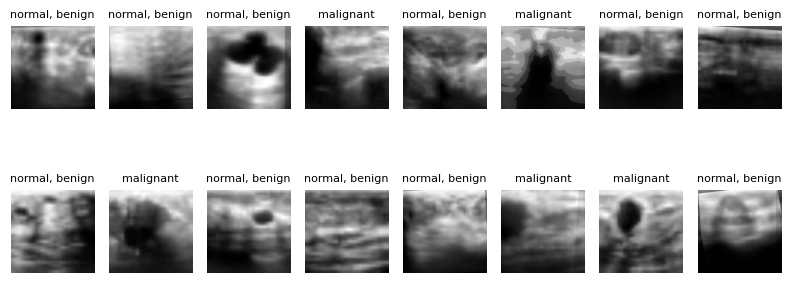

In [ ]:
images, labels = next(iter(train_loader))
images = images[:16]
labels = labels[:16]

fig, axes = plt.subplots(2, 8, figsize=(8, 4))

for i, ax in enumerate(axes.flatten()):
    # Convert the tensor image to numpy array format
    image = images[i].numpy().transpose(1, 2, 0)
    # Normalize the image to the range [0, 1]
    image = (image + 1) / 2
    ax.imshow(image, cmap='gray')
    ax.axis("off")
    ax.set_title(f"{info['label'][str(labels[i].item())]}", fontsize=8)

plt.tight_layout()
plt.show()

## Train

In [ ]:
from torchmetrics import Accuracy, F1Score, ConfusionMatrix
from torchmetrics.classification import BinaryF1Score

def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch=None):
    model.train()
    total_loss = 0.0
    total_acc = 0.0

    # Hint: Implement one training epoch using the provided model, data loader, loss function, and optimizer.
    # Your code should include forward and backward passes, updating the model's parameters, and tracking metrics.
    # Calculate and return the average loss, accuracy, F1-score, and confusion matrix for the epoch.
    # Your code here [20 score]
    f1 = BinaryF1Score()
    confmat = ConfusionMatrix(task="binary", num_classes=2)

    predictions, targets = [], []
    for data in train_loader:
        inputs, labels = data[0].to(device), data[1].to(device) #torch.squeeze(data[1], 1).to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        # weight = torch.zeros_like(labels)
        # weight[labels==0] = 1
        # weight[labels==1] = 2.714
        # loss_fn = nn.BCEWithLogitsLoss(weight=weight)

        loss = loss_fn(outputs, labels.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        preds = (nn.Sigmoid()(outputs) > 0.5).float() # torch.max(outputs, 1)
        # print('output ',preds)
        # print(labels)

        predictions.append(preds.cpu())
        targets.append(labels.cpu())

        total_acc += torch.sum(preds == labels)


    avg_acc = total_acc / len(train_loader.dataset)
    avg_loss = total_loss / len(train_loader)

    predictions = torch.tensor(np.concatenate(predictions))
    targets = torch.tensor(np.concatenate(targets)) # np.squeeze(x, axis=0)

    avg_f1 = f1(predictions, targets)
    cm = confmat(predictions, targets)

    return model, avg_loss, avg_acc, avg_f1, cm


In [ ]:
cm = torch.Tensor([
      [0, 1],
      [0, 0]
    ])

target = torch.Tensor([1, 1, 0, 0])
preds = torch.Tensor([0, 1, 0, 0])
confmat = ConfusionMatrix(task="binary", num_classes=2)
cm + confmat(preds, target)

tensor([[2., 1.],
        [1., 1.]])

In [ ]:
def validate_one_epoch(model, val_loader, criterion):
    model.eval()
    total_loss = 0.0
    total_acc = 0.0

    # Hint: Implement one validation epoch using the provided model, data loader, and loss criterion.
    # Calculate and return the average loss, accuracy, F1-score, and confusion matrix for the epoch.
    # Your code here [20 score]
    f1 = BinaryF1Score()
    confmat = ConfusionMatrix(task="binary", num_classes=2)

    predictions, targets = [], []
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels.float())
            total_loss += loss.item()

            preds = (nn.Sigmoid()(outputs) > 0.5).float()

            predictions.append(preds.cpu())
            targets.append(labels.cpu())

            total_acc += torch.sum(preds == labels)


    avg_acc = total_acc / len(val_loader.dataset)
    avg_loss = total_loss / len(val_loader)

    predictions = torch.tensor(np.concatenate(predictions))
    targets = torch.tensor(np.concatenate(targets)) # np.squeeze(x, axis=0)

    avg_f1 = f1(predictions, targets)
    cm = confmat(predictions, targets)

    return avg_loss, avg_acc, avg_f1, cm

In [ ]:
model = create_model(model_name="swin_tiny_patch4_window7_224",
                        pretrained=True,
                        num_classes=1,
                        in_chans=n_channels)
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
model

In [ ]:
# Training Loop
n_epochs = 100
loss_train_hist = []
loss_valid_hist = []
acc_train_hist = []
acc_valid_hist = []
f1_train_hist = []
f1_valid_hist = []
cm_train_hist = []
cm_valid_hist = []

criterion = nn.BCEWithLogitsLoss()#nn.CrossEntropyLoss()

for epoch in range(n_epochs):
    # torch.cuda.empty_cache()

    model, loss_train, acc_train, f1_train, cm_train = train_one_epoch(model, train_loader, criterion, optimizer, epoch)
    loss_valid, acc_valid, f1_valid, cm_valid = validate_one_epoch(model, val_loader, criterion)

    # Append metrics to history
    loss_train_hist.append(loss_train)
    loss_valid_hist.append(loss_valid)
    acc_train_hist.append(acc_train)
    acc_valid_hist.append(acc_valid)
    f1_train_hist.append(f1_train)
    f1_valid_hist.append(f1_valid)
    cm_train_hist.append(cm_train)
    cm_valid_hist.append(cm_valid)

    print(f"Epoch: {epoch+1}, Train Loss: {loss_train:.2f}, Train Acc: {acc_train:.2f}, Train F1: {f1_train:.2f}, Valid Loss: {loss_valid:.2f}, Valid Acc: {acc_valid:.2f}, Valid F1: {f1_valid:.2f}")


Epoch: 1, Train Loss: 0.61, Train Acc: 0.72, Train F1: 0.84, Valid Loss: 0.58, Valid Acc: 0.73, Valid F1: 0.84
Epoch: 2, Train Loss: 0.59, Train Acc: 0.72, Train F1: 0.83, Valid Loss: 0.53, Valid Acc: 0.73, Valid F1: 0.84
Epoch: 3, Train Loss: 0.55, Train Acc: 0.75, Train F1: 0.85, Valid Loss: 0.47, Valid Acc: 0.85, Valid F1: 0.90
Epoch: 4, Train Loss: 0.54, Train Acc: 0.75, Train F1: 0.85, Valid Loss: 0.44, Valid Acc: 0.85, Valid F1: 0.90
Epoch: 5, Train Loss: 0.50, Train Acc: 0.75, Train F1: 0.84, Valid Loss: 0.53, Valid Acc: 0.73, Valid F1: 0.84
Epoch: 6, Train Loss: 0.48, Train Acc: 0.77, Train F1: 0.86, Valid Loss: 0.40, Valid Acc: 0.83, Valid F1: 0.90
Epoch: 7, Train Loss: 0.43, Train Acc: 0.81, Train F1: 0.88, Valid Loss: 0.37, Valid Acc: 0.82, Valid F1: 0.88
Epoch: 8, Train Loss: 0.39, Train Acc: 0.84, Train F1: 0.90, Valid Loss: 0.40, Valid Acc: 0.83, Valid F1: 0.90
Epoch: 9, Train Loss: 0.40, Train Acc: 0.83, Train F1: 0.89, Valid Loss: 0.40, Valid Acc: 0.83, Valid F1: 0.90
E

In [ ]:
def plot_performance(loss_train_hist, loss_valid_hist, acc_train_hist, acc_valid_hist):
    plt.figure(figsize=(6, 3))

    plt.subplot(1, 2, 1)
    plt.plot(loss_train_hist, label='Train Loss')
    plt.plot(loss_valid_hist, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(torch.tensor(acc_train_hist).cpu(), label='Train Accuracy')
    plt.plot(torch.tensor(acc_valid_hist).cpu(), label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

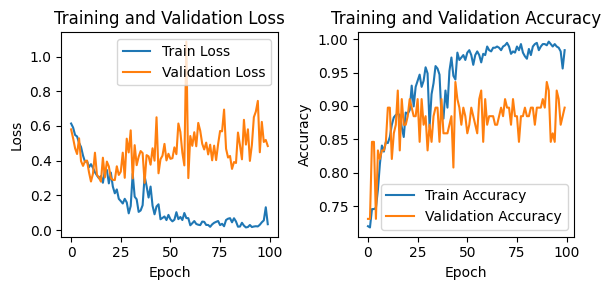

In [ ]:
plot_performance(loss_train_hist, loss_valid_hist, acc_train_hist, acc_valid_hist)

**Discussing the Limitations of Accuracy**

While accuracy is a commonly used metric, it can be misleading, especially in cases of class imbalance. In such scenarios, a model might predict the majority class for all instances, resulting in high accuracy but poor model performance in practical terms.

**Why F1-Score?**
The F1-score is a more robust metric in these cases as it balances precision and recall, providing a better measure of the classifier's performance, especially when the classes are imbalanced.

**Importance of Confusion Matrix**
The confusion matrix provides an in-depth view of the classifier's performance. It shows not just the overall accuracy but how the model performs on each individual class, revealing any biases or weaknesses in the model's predictions.


In [ ]:
import seaborn as sns

def plot_f1_and_confusion_matrix(f1_train, f1_valid, cm_train, cm_valid):
    # Plotting F1-Score
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.bar(['Train F1', 'Valid F1'], [f1_train, f1_valid], color=['blue', 'green'])
    plt.title("F1-Score for Training and Validation")

    # Plotting Confusion Matrix
    plt.subplot(1, 2, 2)
    sns.heatmap(cm_valid, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix for Validation")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

    plt.tight_layout()
    plt.show()

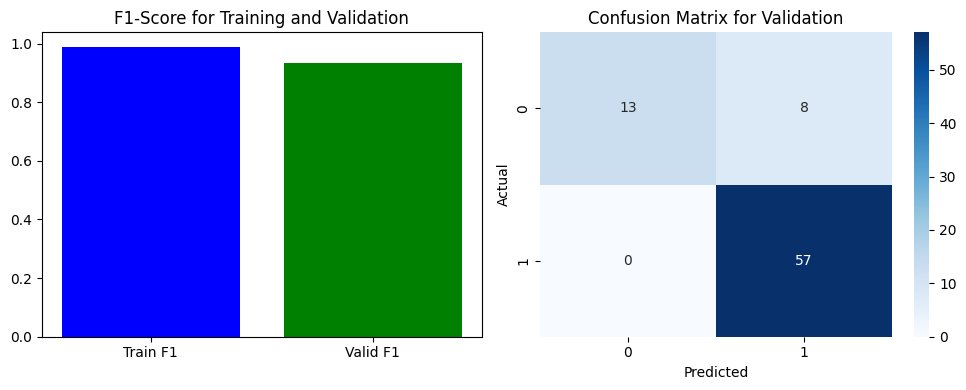

In [ ]:
plot_f1_and_confusion_matrix(f1_train_hist[-1], f1_valid_hist[-1], cm_train_hist[-1], cm_valid_hist[-1])

**Importance of ROC and AUC in Evaluation:**

In medical imaging tasks like ours, accuracy isn't always the best performance metric due to potential class imbalances. Instead, we use ROC (Receiver Operating Characteristic) curves and AUC (Area Under the Curve) to provide a more nuanced view of our model's ability to distinguish between classes, ensuring a more reliable assessment of its diagnostic accuracy.

In [ ]:
from sklearn.metrics import roc_curve, auc

def evaluate_and_plot_roc(model, data_loader, device):
    """
    Evaluates the model on the given data loader, calculates the ROC curve and AUC,
    and plots the ROC curve.

    Parameters:
    model (torch.nn.Module): The trained model to evaluate.
    data_loader (torch.utils.data.DataLoader): DataLoader for evaluation data.
    device (torch.device): The device on which the model is.

    Returns:
    None
    """
    model.eval()

    # Hint: Evaluate the model on the data loader, calculate the ROC curve and AUC using sklearn functions,
    # and plot the ROC curve using matplotlib. Make sure to transfer data to the specified device.
    # Your code here [30 score]
    probabilities, targets = [], []
    with torch.no_grad():
        for data in data_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            # loss = criterion(outputs, labels.float())
            # total_loss += loss.item()

            probs = nn.Sigmoid()(outputs)
            preds = (probs > 0.5).float()

            probabilities.append(probs.cpu())
            targets.append(labels.cpu())

            # total_acc += torch.sum(preds == labels)

    probabilities = torch.tensor(np.concatenate(probabilities))
    predictions = (probabilities > 0.5).float()
    confmat = ConfusionMatrix(task="binary", num_classes=2)

    ns_probs = torch.zeros(probabilities.shape[0])
    targets = torch.tensor(np.concatenate(targets))

    cm = confmat(predictions, targets)
    print(cm)

    ns_fpr, ns_tpr, _ = roc_curve(targets, ns_probs)
    fpr, tpr, thresholds = roc_curve(targets, probabilities)

    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label='Swin Transformer')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()


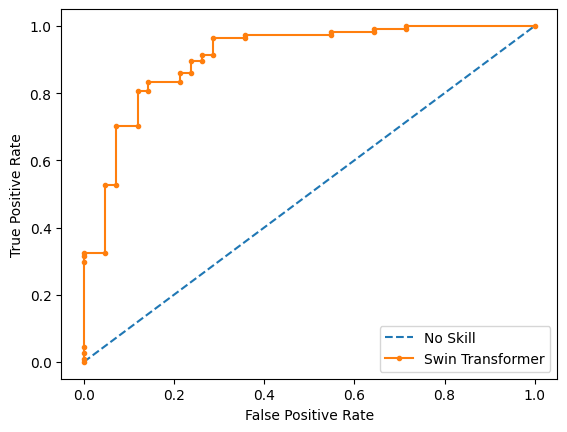

In [ ]:
evaluate_and_plot_roc(model, test_loader, device)

# Addressing Class Imbalance

**Explanation**

Class imbalance is a common challenge in medical data analysis. It happens when the number of examples in one class (usually the 'normal' category) is much larger than in another class (often representing a 'disease' condition). This imbalance can lead to models that are unfairly skewed towards the majority class, performing poorly in identifying the crucial, less represented class.


**Why Address Class Imbalance?**

In medical scenarios, the accuracy of detecting rare conditions (the minority class) is as important, if not more so, than identifying common ones. A model biased towards the majority class might overlook these critical minority cases, leading to potential misdiagnoses.


To counter this, one approach is to use a weighted loss function during training. Follow the following hints to implement it.


In [ ]:
# Hint: To address class imbalance, calculate class weights and apply them to the loss function.
# 1. Calculate class distribution: Count the number of samples in each class.
# 2. Calculate imbalance ratio: Compute the ratio of samples in the majority class to the minority class.
# 3. Create class weights: Create a list or tensor containing the class weights based on the imbalance ratio.
#    You may need to use the inverse of the ratio or other strategies to emphasize the minority class.
# 4. Define the loss function: Use nn.BCEWithLogitsLoss and pass the class_weights as the 'weight' argument.

# Your code here [15 score]

total_samples = len(train_dataset)

normal_count = 0
for sample in train_dataset:
  if sample[1] == 1:
    normal_count+=1
malig_count = total_samples - normal_count

print('Ratio of samples in the majority class to the minority class: ', normal_count / malig_count)

class0_weight = total_samples / (malig_count * 2) # malignant
class1_weight = total_samples / (normal_count * 2) # normal

print('\nClass0 : Malignant (Minority Class) Weight = ', class0_weight, 'or ', 1)
print('Class1 : Normal, Benign (Majority Class) Weight = ', class1_weight, 'or ', malig_count / normal_count)

pos_weight = torch.tensor([malig_count / normal_count]).to(device) # or: weight = torch.tensor([class0_weight, class1_weight]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight) # or: (weight=weight)

Ratio of samples in the majority class to the minority class:  2.7142857142857144

Class0 : Malignant (Minority Class) Weight =  1.8571428571428572
Class1 : Normal, Benign (Majority Class) Weight =  0.6842105263157895


In [ ]:
model = create_model(model_name="swin_tiny_patch4_window7_224",
                        pretrained=True,
                        num_classes=1,
                        in_chans=n_channels)
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
model

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(1, 96, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  )
  (layers): Sequential(
    (0): SwinTransformerStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path1): Identity()
          (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=96, out_features=384, bias=True)
            (act): GELU(approximate='none')
            (drop1): 

In [ ]:
# Training Loop
n_epochs = 100
loss_train_hist = []
loss_valid_hist = []
acc_train_hist = []
acc_valid_hist = []
f1_train_hist = []
f1_valid_hist = []
cm_train_hist = []
cm_valid_hist = []

for epoch in range(n_epochs):
    torch.cuda.empty_cache()

    model, loss_train, acc_train, f1_train, cm_train = train_one_epoch(model, train_loader, criterion, optimizer, epoch)
    loss_valid, acc_valid, f1_valid, cm_valid = validate_one_epoch(model, val_loader, criterion)

    loss_train_hist.append(loss_train)
    loss_valid_hist.append(loss_valid)
    acc_train_hist.append(acc_train)
    acc_valid_hist.append(acc_valid)
    f1_train_hist.append(f1_train)
    f1_valid_hist.append(f1_valid)
    cm_train_hist.append(cm_train)
    cm_valid_hist.append(cm_valid)

    print(f"Epoch: {epoch+1}, Train Loss: {loss_train:.2f}, Train Acc: {acc_train:.2f}, Train F1: {f1_train:.2f}, Valid Loss: {loss_valid:.2f}, Valid Acc: {acc_valid:.2f}, Valid F1: {f1_valid:.2f}")

Epoch: 1, Train Loss: 0.37, Train Acc: 0.60, Train F1: 0.70, Valid Loss: 0.34, Valid Acc: 0.76, Valid F1: 0.83
Epoch: 2, Train Loss: 0.31, Train Acc: 0.70, Train F1: 0.78, Valid Loss: 0.28, Valid Acc: 0.76, Valid F1: 0.83
Epoch: 3, Train Loss: 0.31, Train Acc: 0.69, Train F1: 0.77, Valid Loss: 0.27, Valid Acc: 0.82, Valid F1: 0.88
Epoch: 4, Train Loss: 0.29, Train Acc: 0.72, Train F1: 0.79, Valid Loss: 0.29, Valid Acc: 0.85, Valid F1: 0.90
Epoch: 5, Train Loss: 0.29, Train Acc: 0.78, Train F1: 0.84, Valid Loss: 0.24, Valid Acc: 0.87, Valid F1: 0.91
Epoch: 6, Train Loss: 0.28, Train Acc: 0.77, Train F1: 0.83, Valid Loss: 0.26, Valid Acc: 0.83, Valid F1: 0.88
Epoch: 7, Train Loss: 0.26, Train Acc: 0.79, Train F1: 0.85, Valid Loss: 0.23, Valid Acc: 0.73, Valid F1: 0.79
Epoch: 8, Train Loss: 0.25, Train Acc: 0.78, Train F1: 0.84, Valid Loss: 0.29, Valid Acc: 0.81, Valid F1: 0.87
Epoch: 9, Train Loss: 0.24, Train Acc: 0.80, Train F1: 0.86, Valid Loss: 0.22, Valid Acc: 0.79, Valid F1: 0.85
E

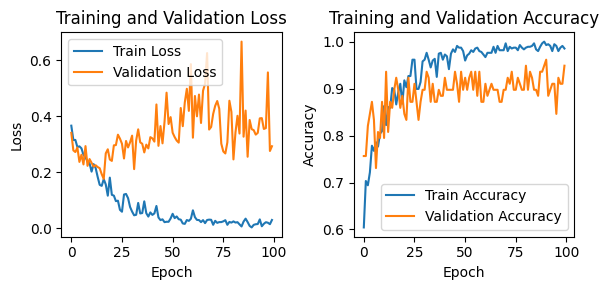

In [ ]:
plot_performance(loss_train_hist, loss_valid_hist, acc_train_hist, acc_valid_hist)

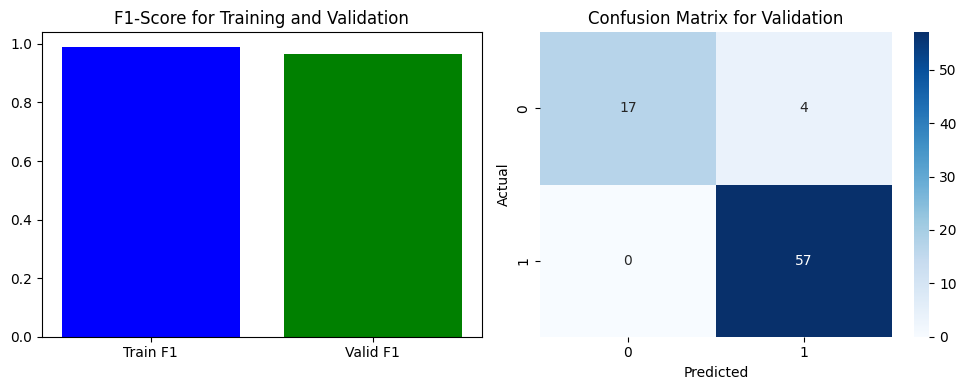

In [ ]:
plot_f1_and_confusion_matrix(f1_train_hist[-1], f1_valid_hist[-1], cm_train_hist[-1], cm_valid_hist[-1])

tensor([[ 32,  10],
        [ 10, 104]])


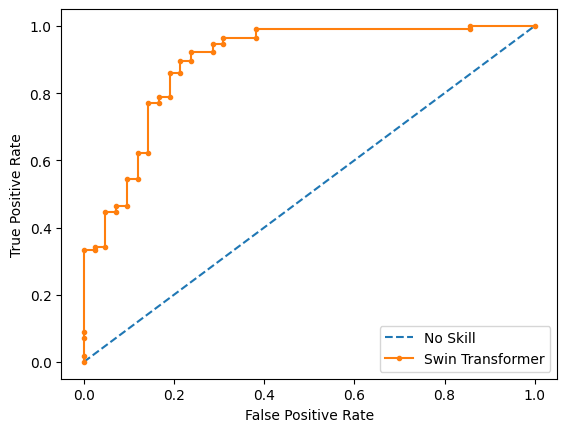

In [ ]:
evaluate_and_plot_roc(model, test_loader, device)

In this notebook, you've already learned about addressing imbalanced data using a weighted loss. Now, let's explore an alternative method for tackling class imbalance in machine learning. Please describe and explain this alternative approach.



```
# Your answer here [15 score]
```
The 2 common solutions in class imbalance problem are:
1. Undersampling/Oversampling
2. Consider other classification metrics

**Undersampling/Oversampling**           
Resampling is a common technique used to address class imbalance. For example if we have class imbalance problem we can fix it in 2 ways, undersampling the major class or oversampling the minor class.     
Undersampling is the technique that we select a subset of major class samples instead of whole samples. Oversampling is the technique that we generate new samples for minor class with copying the existing samples or augmenting minor class samples with data augmentation approaches.

**Consider other classification metrics**         
Sometimes accuracy is not good metric to evaluate the model's performance. We can consider confusion matrix and use another metric as the main metric for evaluation.
For example if negative class is the minor class, we may care more about false positive rate that is calculated as the number of false positive predictions divided by the total number of actual negative samples. So we should minimize false positive rate or use the negative rate(1 - false positive rate) as main metric to evaluate the model.

